<a href="https://colab.research.google.com/github/chris051091/Tesis_Maestria/blob/main/preprocess/src/Testeo%20Temperatura.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Testes - Temperatura

Una vez que los datos son alistados, se realiza el análisis de testes.

Para temperatura, se consideran los siguientes testes:

- Test de rango fijo
- Tests de consistencia interna
- Test de ceros
- Test para el salto térmico diario
- Tests de rango dinámico, consistencia temporal, persistencia y coherencia espacial

In [1]:
import pandas as pd
import numpy as np
import os
import re
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from google.colab import drive
drive.mount('/content/drive')

%matplotlib inline

Mounted at /content/drive


In [27]:
PATH_DRIVE = 'drive/MyDrive/Seminario-3-master'
PATH_DADOS = '/preprocess/dados/'
PATH_FIGURE = '/histograms/'

# NOMBRE_ESTACION = 'chucuri'
NOMBRE_ESTACION = 'palanquero'
#NOMBRE_ESTACION = 'vizcaina'

PATH_FINAL_DADOS = PATH_DRIVE + PATH_DADOS + NOMBRE_ESTACION + '/'
PATH_FINAL_DADOS_TRATADOS = PATH_DRIVE + PATH_DADOS + NOMBRE_ESTACION + '/tratados/'

FILE_DATOS_PROCESADOS = NOMBRE_ESTACION.lower() + '_procesado.csv'
FILE_DATOS_TRATADOS = NOMBRE_ESTACION.lower() + '_tratados_temp.csv'


In [28]:
df = pd.read_csv(PATH_FINAL_DADOS + FILE_DATOS_PROCESADOS,
                 sep = ';',
                 parse_dates = ["FECHA"],
                 date_parser = lambda col: pd.to_datetime(col)
                )

dfTemp = df[['FECHA', 'TEMP']].copy()
dfTemp = dfTemp.sort_values(by=['FECHA']).reset_index(drop = True)
dfTemp

,FECHA,TEMP
0,2011-01-01 01:00:00-05:00,22.7
1,2011-01-01 02:00:00-05:00,23.1
2,2011-01-01 03:00:00-05:00,23.3
3,2011-01-01 04:00:00-05:00,24.1
4,2011-01-01 05:00:00-05:00,22.9
...,...,...
48875,2017-12-31 19:00:00-05:00,25.2
48876,2017-12-31 20:00:00-05:00,24.4
48877,2017-12-31 21:00:00-05:00,23.9
48878,2017-12-31 22:00:00-05:00,24.0


## Test de rango fijo

In [29]:
t_max = 40.
t_min = 20.
lamb_func = lambda r: np.nan if ((r > t_max) | (r < t_min)) else r
dfTemp['TEMP_RANGO_FIJO'] = dfTemp['TEMP'].apply(lamb_func)
dfTemp

,FECHA,TEMP,TEMP_RANGO_FIJO
0,2011-01-01 01:00:00-05:00,22.7,22.7
1,2011-01-01 02:00:00-05:00,23.1,23.1
2,2011-01-01 03:00:00-05:00,23.3,23.3
3,2011-01-01 04:00:00-05:00,24.1,24.1
4,2011-01-01 05:00:00-05:00,22.9,22.9
...,...,...,...
48875,2017-12-31 19:00:00-05:00,25.2,25.2
48876,2017-12-31 20:00:00-05:00,24.4,24.4
48877,2017-12-31 21:00:00-05:00,23.9,23.9
48878,2017-12-31 22:00:00-05:00,24.0,24.0


<Axes: xlabel='FECHA', ylabel='TEMP_RANGO_FIJO'>

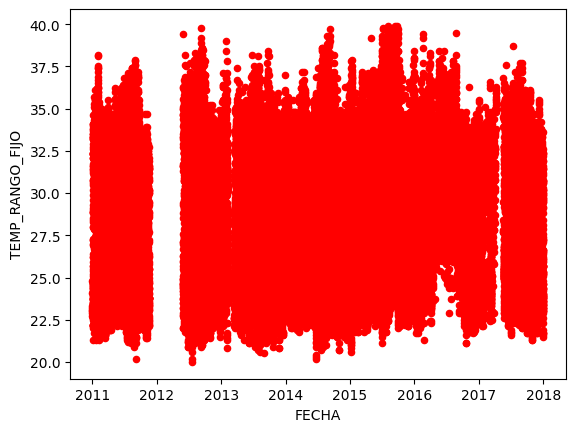

In [30]:
#ax = dfTemp.plot(kind = 'scatter', x='FECHA', y='TEMP')
dfTemp.plot(kind = 'scatter', x='FECHA', y='TEMP_RANGO_FIJO', color='red')

In [31]:
dfTemp['FECHA_DIA'] = dfTemp['FECHA'].dt.date
dfAux = (dfTemp.groupby('FECHA_DIA')
       .agg({'TEMP_RANGO_FIJO': ['mean', 'min', 'max']})
       .reset_index(level = [0])
)
dfAux = (dfAux.sort_values(by = 'FECHA_DIA'))
dfAux['TEMP_MAX_D_1'] = (dfAux[('TEMP_RANGO_FIJO', 'max')].shift(1))
dfAux['TEMP_MIN_D_1'] = (dfAux[('TEMP_RANGO_FIJO', 'min')].shift(1))

dfCons = (pd.merge(dfTemp,dfAux,on='FECHA_DIA', how='outer')
            .rename(columns = {('TEMP_RANGO_FIJO', 'mean') : 'TEMP_PROM_DIARIA',
                                 ('TEMP_RANGO_FIJO', 'min') : 'TEMP_MIN_DIARIA',
                                 ('TEMP_RANGO_FIJO', 'max') : 'TEMP_MAX_DIARIA',
                                 ('TEMP_MAX_D_1', ''): 'TEMP_MAX_D_1',
                              ('TEMP_MIN_D_1', ''): 'TEMP_MIN_D_1',})
        )
dfCons['FECHA_DIA'] = dfCons['FECHA_DIA'].apply(lambda x: x.strftime('%Y-%m-%d'))
dfCons['TEMP_SH_2'] = (dfCons['TEMP'].shift(1))
dfCons['TEMP_LIST'] = [window.to_list() for window in dfCons['TEMP'].rolling(window=5)]

dfCons['FORM_2_30'] = np.where((dfCons['TEMP_MAX_DIARIA'] > dfCons['TEMP_PROM_DIARIA'])
                                    & (dfCons['TEMP_MIN_DIARIA'] < dfCons['TEMP_PROM_DIARIA']), 1, 0)

ant_null_act_notnull = lambda df, t_act, t_ant: ~df[t_act].isnull() & df[t_ant].isnull()
ant_notnull_act_notnull = lambda df, t_act, t_ant: ~df[t_act].isnull() & ~df[t_ant].isnull()

dfCons['FORM_2_33'] = np.where( (dfCons['FORM_2_30'] == 1) & ((ant_null_act_notnull(dfCons, 'TEMP_MAX_DIARIA', 'TEMP_MIN_D_1')) | (dfCons['TEMP_MAX_DIARIA'] > dfCons['TEMP_MIN_D_1'])), 1, 0)
dfCons['FORM_2_34'] = np.where( (dfCons['FORM_2_33'] == 1) & ((ant_null_act_notnull(dfCons, 'TEMP_MIN_DIARIA', 'TEMP_MAX_D_1')) | (dfCons['TEMP_MIN_DIARIA'] <= dfCons['TEMP_MAX_D_1'])), 1, 0)
dfCons['FORM_2_35'] = np.where( (dfCons['FORM_2_34'] == 1) & (dfCons['TEMP_MAX_DIARIA'] - dfCons['TEMP_MIN_DIARIA'] < 23.8), 1, 0)
# Ecuación 2.36 --> Si ya tenemos los valores dentro de un rango, para que verificar si tengo tres dias seguidos con t min = 0?

dfCons['FORM_2_37'] = (np.where((dfCons['FORM_2_35'] == 1) &
                                ((ant_null_act_notnull(dfCons, 'TEMP', 'TEMP_SH_2')) |
                                 (((~dfCons['TEMP_SH_2'].isnull()) & (~dfCons['TEMP'].isnull())) &
                                  (np.abs(dfCons['TEMP'] - dfCons['TEMP_SH_2']) < 4))), 1, 0))

# check_size_list = lambda r: 1 if len(list(set([str(x) for x in r]))) == 4 else 0
check_size_list = lambda r: 0 if ((np.isnan(r[-1])) | ((all([x == r[-1] for x in r])) & len(r) == 5)) else 1
dfCons['NO_REPETIDO'] = dfCons['TEMP_LIST'].apply(check_size_list)

dfCons['FORM_2_38'] = np.where( (dfCons['FORM_2_37'] == 1) & (dfCons['NO_REPETIDO'] == 1), 1, 0)

####  Quedamos en la formula 2.38 #####

<ipython-input-31-a3d308f3ec31>:10: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  dfCons = (pd.merge(dfTemp,dfAux,on='FECHA_DIA', how='outer')
<ipython-input-31-a3d308f3ec31>:10: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  dfCons = (pd.merge(dfTemp,dfAux,on='FECHA_DIA', how='outer')


In [32]:
## Para filtrar los valores finales
dfFinal = dfCons[dfCons['FORM_2_38'] == 1].reset_index(drop=True)
dfFinal

,FECHA,TEMP,TEMP_RANGO_FIJO,FECHA_DIA,TEMP_PROM_DIARIA,TEMP_MIN_DIARIA,TEMP_MAX_DIARIA,TEMP_MAX_D_1,TEMP_MIN_D_1,TEMP_SH_2,TEMP_LIST,FORM_2_30,FORM_2_33,FORM_2_34,FORM_2_35,FORM_2_37,NO_REPETIDO,FORM_2_38
0,2011-01-01 01:00:00-05:00,22.7,22.7,2011-01-01,27.356522,22.7,33.5,NaN,NaN,NaN,[22.7],1,1,1,1,1,1,1
1,2011-01-01 02:00:00-05:00,23.1,23.1,2011-01-01,27.356522,22.7,33.5,NaN,NaN,22.7,"[22.7, 23.1]",1,1,1,1,1,1,1
2,2011-01-01 03:00:00-05:00,23.3,23.3,2011-01-01,27.356522,22.7,33.5,NaN,NaN,23.1,"[22.7, 23.1, 23.3]",1,1,1,1,1,1,1
3,2011-01-01 04:00:00-05:00,24.1,24.1,2011-01-01,27.356522,22.7,33.5,NaN,NaN,23.3,"[22.7, 23.1, 23.3, 24.1]",1,1,1,1,1,1,1
4,2011-01-01 05:00:00-05:00,22.9,22.9,2011-01-01,27.356522,22.7,33.5,NaN,NaN,24.1,"[22.7, 23.1, 23.3, 24.1, 22.9]",1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45464,2017-12-31 19:00:00-05:00,25.2,25.2,2017-12-31,26.025000,22.6,30.7,31.9,22.9,26.6,"[30.2, 30.2, 29.7, 26.6, 25.2]",1,1,1,1,1,1,1
45465,2017-12-31 20:00:00-05:00,24.4,24.4,2017-12-31,26.025000,22.6,30.7,31.9,22.9,25.2,"[30.2, 29.7, 26.6, 25.2, 24.4]",1,1,1,1,1,1,1
45466,2017-12-31 21:00:00-05:00,23.9,23.9,2017-12-31,26.025000,22.6,30.7,31.9,22.9,24.4,"[29.7, 26.6, 25.2, 24.4, 23.9]",1,1,1,1,1,1,1
45467,2017-12-31 22:00:00-05:00,24.0,24.0,2017-12-31,26.025000,22.6,30.7,31.9,22.9,23.9,"[26.6, 25.2, 24.4, 23.9, 24.0]",1,1,1,1,1,1,1


In [33]:
print(dfFinal['TEMP'].max())
print(dfFinal['TEMP_MAX_DIARIA'].max())
print(dfFinal['TEMP'].mean())

40.8
39.9
27.694607314873867


In [34]:
print(dfFinal['TEMP'].min())
print(dfFinal['TEMP_MIN_DIARIA'].min())
print(dfFinal['TEMP_PROM_DIARIA'].mean())

20.0
20.0
27.698062330159757


## Metadatos del dataset

In [35]:
print(f'Datos iniciales : {dfTemp.shape[0]}')
dftemp_null= dfTemp[dfTemp["TEMP"].isnull()]
print(f'Datos nulos : {dfTemp[dfTemp["TEMP"].isnull()].shape[0]}')
print(f'Datos nulos después de los testes : {dfFinal[dfFinal["TEMP"].isnull()].shape[0]}')
print(f'Datos finales después de testes : {dfFinal.shape[0]}')
print(f'Datos no nulos que fueron eliminados en los testes : {dfTemp.shape[0] - dfFinal.shape[0] - dfTemp[dfTemp["TEMP"].isnull()].shape[0]}')

Datos iniciales : 48880
Datos nulos : 2552
Datos nulos después de los testes : 0
Datos finales después de testes : 45469
Datos no nulos que fueron eliminados en los testes : 859


In [36]:
dftemp_null

,FECHA,TEMP,TEMP_RANGO_FIJO,FECHA_DIA
3611,2011-05-31 12:00:00-05:00,NaN,NaN,2011-05-31
3612,2011-05-31 13:00:00-05:00,NaN,NaN,2011-05-31
3613,2011-05-31 14:00:00-05:00,NaN,NaN,2011-05-31
3614,2011-05-31 15:00:00-05:00,NaN,NaN,2011-05-31
3615,2011-05-31 16:00:00-05:00,NaN,NaN,2011-05-31
...,...,...,...,...
43854,2017-04-02 14:00:00-05:00,NaN,NaN,2017-04-02
43855,2017-04-02 15:00:00-05:00,NaN,NaN,2017-04-02
43856,2017-04-02 16:00:00-05:00,NaN,NaN,2017-04-02
43895,2017-05-20 09:00:00-05:00,NaN,NaN,2017-05-20


In [37]:
dfFinal[['FECHA', 'TEMP']].to_csv(PATH_FINAL_DADOS_TRATADOS + FILE_DATOS_TRATADOS, header=True, index=False, sep = ';')

In [38]:
dftemp_null['FECHA'] = pd.to_datetime(dftemp_null['FECHA'], format='%Y %m %d %H %M').dt.tz_convert('America/Bogota')

<ipython-input-38-39b97ae0a396>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dftemp_null['FECHA'] = pd.to_datetime(dftemp_null['FECHA'], format='%Y %m %d %H %M').dt.tz_convert('America/Bogota')


In [39]:
dftemp_null['HORA_FECHA'] = dftemp_null['FECHA'].dt.hour
dftemp_null['MES_FECHA'] = dftemp_null['FECHA'].dt.month
dftemp_null['ANO_FECHA'] = dftemp_null['FECHA'].dt.year

<ipython-input-39-31ce48ccc9f6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dftemp_null['HORA_FECHA'] = dftemp_null['FECHA'].dt.hour
<ipython-input-39-31ce48ccc9f6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dftemp_null['MES_FECHA'] = dftemp_null['FECHA'].dt.month
<ipython-input-39-31ce48ccc9f6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

In [40]:
dftemp_null

,FECHA,TEMP,TEMP_RANGO_FIJO,FECHA_DIA,HORA_FECHA,MES_FECHA,ANO_FECHA
3611,2011-05-31 12:00:00-05:00,NaN,NaN,2011-05-31,12,5,2011
3612,2011-05-31 13:00:00-05:00,NaN,NaN,2011-05-31,13,5,2011
3613,2011-05-31 14:00:00-05:00,NaN,NaN,2011-05-31,14,5,2011
3614,2011-05-31 15:00:00-05:00,NaN,NaN,2011-05-31,15,5,2011
3615,2011-05-31 16:00:00-05:00,NaN,NaN,2011-05-31,16,5,2011
...,...,...,...,...,...,...,...
43854,2017-04-02 14:00:00-05:00,NaN,NaN,2017-04-02,14,4,2017
43855,2017-04-02 15:00:00-05:00,NaN,NaN,2017-04-02,15,4,2017
43856,2017-04-02 16:00:00-05:00,NaN,NaN,2017-04-02,16,4,2017
43895,2017-05-20 09:00:00-05:00,NaN,NaN,2017-05-20,9,5,2017


In [41]:
datos_total_ano = 24*365
datos_total_mes = 24*7*30
datos_total_hora = 7*365
print(datos_total_ano)
print(datos_total_mes)
print(datos_total_hora)

8760
5040
2555


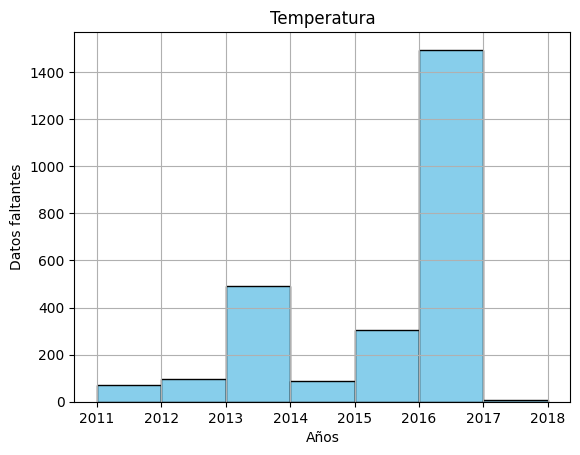

In [42]:
fig, ax = plt.subplots()

# Gráfico del histograma
dftemp_null['ANO_FECHA'].plot(kind = 'hist', ax=ax, edgecolor='black', color='skyblue', bins = range(2011, 2019))

# # Gráfico de la estimativa de la densidad del kernel en el mismo gráfico sobre el mismo gráfico
# ax2 = df['hour_min_t'].plot(kind='kde', secondary_y=True, ax=ax, color='red')
# ax2.set_ylabel("Densidad")

ax.set_ylim(0)
ax.set_xlim()
ax.grid(True)
ax.set_xlabel("Años")
ax.set_xticks(range(2011, 2019))
ax.set_title('Temperatura')
ax.set_ylabel("Datos faltantes")
plt.savefig(PATH_DRIVE + PATH_FIGURE + 'Histograma_año_datos_faltantes_Temp.png', format='png')

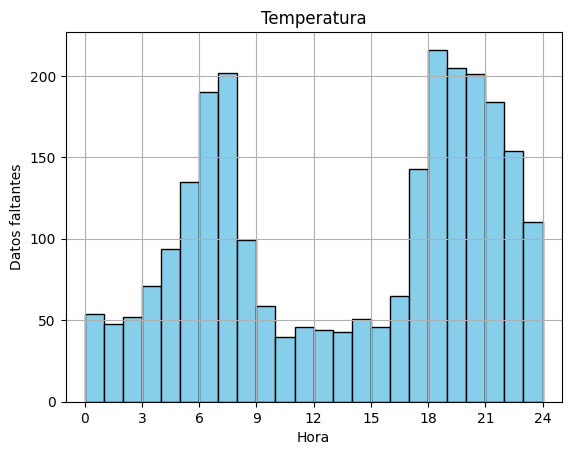

In [43]:
fig, ax = plt.subplots()

# Gráfico del histograma
dftemp_null['HORA_FECHA'].plot(kind = 'hist', ax=ax, edgecolor='black', color='skyblue', bins = range(0, 25))

# # Gráfico de la estimativa de la densidad del kernel en el mismo gráfico sobre el mismo gráfico
# ax2 = df['hour_min_t'].plot(kind='kde', secondary_y=True, ax=ax, color='red')
# ax2.set_ylabel("Densidad")

ax.set_ylim(0)
ax.set_xlim(-1, 25)
ax.grid(True)
ax.set_xlabel("Hora")
ax.set_xticks(range(0, 25, 3))
ax.set_title('Temperatura')
ax.set_ylabel("Datos faltantes")
plt.savefig(PATH_DRIVE + PATH_FIGURE + 'Histograma_hora_datos_faltantes_Temp.png', format='png')

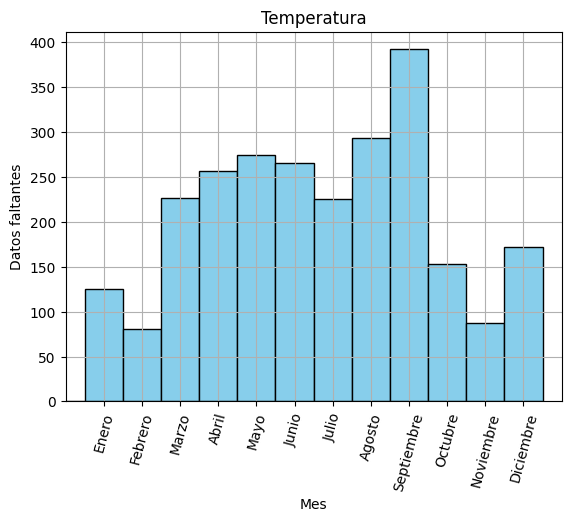

In [44]:
fig, ax = plt.subplots()

# Gráfico del histograma
dftemp_null['MES_FECHA'].plot(kind = 'hist', ax=ax, edgecolor='black', color='skyblue', bins = range(0,14), align='left')

# # Gráfico de la estimativa de la densidad del kernel en el mismo gráfico sobre el mismo gráfico
# ax2 = df['month_min_t'].plot(kind='kde', secondary_y=True, ax=ax, color='red')
# ax2.set_ylabel("Densidad")

ax.set_ylim(0)
ax.set_xlim(0, 13)
# bins_labels(range(0,14), 20)
ax.grid(True)
ax.set_xlabel("Mes")
ax.set_xticks(range(1, 13, 1))
Meses = ['Enero', 'Febrero',
         'Marzo', 'Abril',
         'Mayo', 'Junio',
         'Julio', 'Agosto',
         'Septiembre', 'Octubre',
         'Noviembre', 'Diciembre']
ax.set_xticklabels(Meses, rotation=75)
ax.set_title('Temperatura')
ax.set_ylabel("Datos faltantes")
plt.savefig(PATH_DRIVE + PATH_FIGURE + 'Histograma_mes_datos_faltantes_Temp.png', format='png')


In [45]:
dfTemp ## Dataframe Total
dfFinal ## Dataframe después de realizar los testeos y remover los valores nulos
dftemp_null ## Dataframe con solamente los valores nulos

,FECHA,TEMP,TEMP_RANGO_FIJO,FECHA_DIA,HORA_FECHA,MES_FECHA,ANO_FECHA
3611,2011-05-31 12:00:00-05:00,NaN,NaN,2011-05-31,12,5,2011
3612,2011-05-31 13:00:00-05:00,NaN,NaN,2011-05-31,13,5,2011
3613,2011-05-31 14:00:00-05:00,NaN,NaN,2011-05-31,14,5,2011
3614,2011-05-31 15:00:00-05:00,NaN,NaN,2011-05-31,15,5,2011
3615,2011-05-31 16:00:00-05:00,NaN,NaN,2011-05-31,16,5,2011
...,...,...,...,...,...,...,...
43854,2017-04-02 14:00:00-05:00,NaN,NaN,2017-04-02,14,4,2017
43855,2017-04-02 15:00:00-05:00,NaN,NaN,2017-04-02,15,4,2017
43856,2017-04-02 16:00:00-05:00,NaN,NaN,2017-04-02,16,4,2017
43895,2017-05-20 09:00:00-05:00,NaN,NaN,2017-05-20,9,5,2017


## Análisis de datos faltantes

In [46]:
from calendar import isleap

In [47]:
dfEliminados = dfCons[dfCons['FORM_2_38'] == 0].reset_index(drop=True)[['FECHA', 'TEMP']].copy()
dfEliminados['HORA_FECHA'] = dfEliminados['FECHA'].dt.hour
dfEliminados['MES_FECHA'] = dfEliminados['FECHA'].dt.month
dfEliminados['ANO_FECHA'] = dfEliminados['FECHA'].dt.year
dfEliminados['DIAS_EN_MES'] = dfEliminados['FECHA'].dt.days_in_month
dfEliminados['DIAS_EN_ANO'] = dfEliminados["ANO_FECHA"].apply(lambda x:365 + isleap(x))

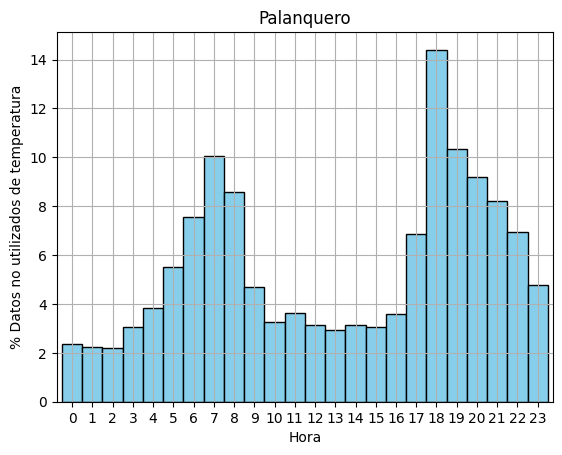

In [48]:
dfEliminados_HORA = (dfEliminados.groupby('HORA_FECHA')
       .agg({'HORA_FECHA': ['count']})
       .reset_index(level = [0])
      )

dfEliminados_HORA["TOTAL_FALTANTES"] = dfEliminados_HORA[("HORA_FECHA", "count")]
dfEliminados_HORA["HORA"] = dfEliminados_HORA[("HORA_FECHA", "")]
dfEliminados_HORA["TOTAL_HORA"] = 7*365
dfEliminados_HORA["PORC_HORA_FALTANTE"] = dfEliminados_HORA["TOTAL_FALTANTES"] / dfEliminados_HORA["TOTAL_HORA"] * 100

fig, ax = plt.subplots()

dfEliminados_HORA.plot.bar(x='HORA', y='PORC_HORA_FALTANTE', rot=0, edgecolor='black', color='skyblue', width=1.0, ax=ax)
ax.grid(True)
ax.set_xlabel("Hora")
ax.set_ylabel("% Datos no utilizados de temperatura")
ax.get_legend().remove()
ax.set_title(f'{NOMBRE_ESTACION.capitalize()}')
plt.savefig(PATH_DRIVE + PATH_FIGURE + 'Histograma_datos_faltantes_porcentual_Temp_hora.png', format='png')


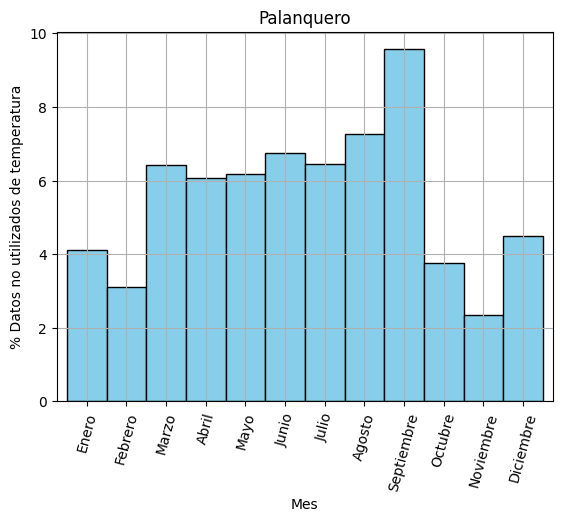

In [49]:
dfEliminados_MES = (dfEliminados
       .groupby(['MES_FECHA', 'ANO_FECHA', 'DIAS_EN_MES'])
       .agg({'HORA_FECHA': ['count']})
       .reset_index(level = [0, 1, 2])
      )

dfEliminados_MES["TOTAL_FALTANTES"] = dfEliminados_MES[("HORA_FECHA", "count")]
dfEliminados_MES = dfEliminados_MES.drop(columns=[("HORA_FECHA", "count")])
dfEliminados_MES["TOTAL_DATOS_POR_MES_ANO"] = dfEliminados_MES['DIAS_EN_MES']*24*7
dfEliminados_MES["PORC_DATOS_POR_MES_ANO_FALTANTE"] = dfEliminados_MES["TOTAL_FALTANTES"] / dfEliminados_MES["TOTAL_DATOS_POR_MES_ANO"] * 100
dfEliminados_MES.columns=dfEliminados_MES.columns.droplevel(1)
dfEliminados_MES.reset_index(inplace=True)
dfEliminados_MES = (dfEliminados_MES
       .groupby('MES_FECHA')
       .agg({'PORC_DATOS_POR_MES_ANO_FALTANTE': ['sum']})
       .reset_index(level = [0])
      )
dfEliminados_MES["PORC_MES_FALTANTES"] = dfEliminados_MES[("PORC_DATOS_POR_MES_ANO_FALTANTE", "sum")]

fig, ax = plt.subplots()

dfEliminados_MES.plot.bar(x='MES_FECHA', y='PORC_MES_FALTANTES', rot=0, edgecolor='black', color='skyblue', width=1.0, ax=ax)
ax.grid(True)
ax.set_xlabel("Mes")
ax.set_ylabel("% Datos no utilizados de temperatura")
ax.get_legend().remove()
Meses = ['Enero', 'Febrero',
         'Marzo', 'Abril',
         'Mayo', 'Junio',
         'Julio', 'Agosto',
         'Septiembre', 'Octubre',
         'Noviembre', 'Diciembre']
ax.set_xticklabels(Meses, rotation=75)
ax.set_title(f'{NOMBRE_ESTACION.capitalize()}')
plt.savefig(PATH_DRIVE + PATH_FIGURE + 'Histograma_datos_faltantes_porcentual_Temp_mes.png', format='png')

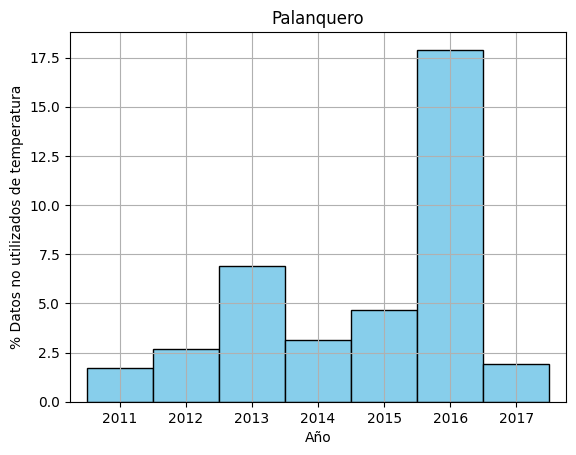

In [50]:
dfEliminados_ANO = (dfEliminados
       .groupby(['ANO_FECHA', 'DIAS_EN_ANO'])
       .agg({'HORA_FECHA': ['count']})
       .reset_index(level = [0, 1])
      )

dfEliminados_ANO["TOTAL_FALTANTES"] = dfEliminados_ANO[("HORA_FECHA", "count")]
dfEliminados_ANO = dfEliminados_ANO.drop(columns=[("HORA_FECHA", "count")])
dfEliminados_ANO["TOTAL_DATOS_POR_ANO"] = dfEliminados_ANO['DIAS_EN_ANO']*24
dfEliminados_ANO["PORC_ANO_FALTANTES"] = dfEliminados_ANO["TOTAL_FALTANTES"] / dfEliminados_ANO["TOTAL_DATOS_POR_ANO"] * 100
dfEliminados_ANO
fig, ax = plt.subplots()

dfEliminados_ANO.plot.bar(x='ANO_FECHA', y='PORC_ANO_FALTANTES', rot=0, edgecolor='black', color='skyblue', width=1.0, ax=ax)
ax.grid(True)
ax.set_xlabel("Año")
ax.set_ylabel("% Datos no utilizados de temperatura")
ax.get_legend().remove()
ax.set_title(f'{NOMBRE_ESTACION.capitalize()}')
plt.savefig(PATH_DRIVE + PATH_FIGURE + 'Histograma_datos_faltantes_porcentual_Temp_ano.png', format='png')